In [31]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from nltk.stem.porter import PorterStemmer
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [34]:
def data():
    global X_train, X_test, y_train, y_test, max_features, maxlen
    maxlen = 120
    max_features = 10000

    print('Loading data...')
    (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')

    print("Pad sequences (samples x time)")
    X_train = pad_sequences(X_train, maxlen=maxlen)
    X_test = pad_sequences(X_test, maxlen=maxlen)
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)

    return X_train, X_test, y_train, y_test, max_features, maxlen 

In [35]:
data1 = data()

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 120)
X_test shape: (25000, 120)
y_train shape: (25000,)
y_test shape: (25000,)


In [36]:
stop = stopwords.words('english')
w1 = WordNetLemmatizer()
stemmer = PorterStemmer()

In [37]:
#LSTM
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(10000, 32, input_length=120))
lstm_model.add(keras.layers.LSTM(100, return_sequences = True))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.LSTM(100, return_sequences = False))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [38]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [39]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)
mcp_save = keras.callbacks.ModelCheckpoint('checkpoint_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [40]:
history = lstm_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data = (X_test, y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])

Epoch 1/15
782/782 [==============================] - 73s 90ms/step - loss: 0.4293 - accuracy: 0.8051 - val_loss: 0.3440 - val_accuracy: 0.8567

Epoch 00001: val_loss improved from inf to 0.34398, saving model to checkpoint_model.hdf5
Epoch 2/15
782/782 [==============================] - 84s 107ms/step - loss: 0.2974 - accuracy: 0.8819 - val_loss: 0.3790 - val_accuracy: 0.8376

Epoch 00002: val_loss did not improve from 0.34398
Epoch 3/15
782/782 [==============================] - 77s 98ms/step - loss: 0.2622 - accuracy: 0.8976 - val_loss: 0.3665 - val_accuracy: 0.8541

Epoch 00003: val_loss did not improve from 0.34398
Epoch 4/15
782/782 [==============================] - 93s 120ms/step - loss: 0.2363 - accuracy: 0.9091 - val_loss: 0.3753 - val_accuracy: 0.8618

Epoch 00004: val_loss did not improve from 0.34398
Epoch 5/15
782/782 [==============================] - 95s 122ms/step - loss: 0.2176 - accuracy: 0.9188 - val_loss: 0.6022 - val_accuracy: 0.7826

Epoch 00005: val_loss did not

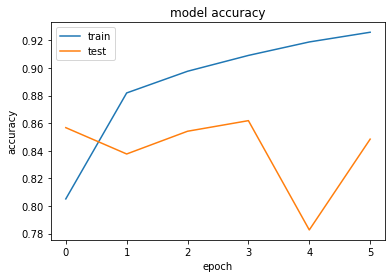

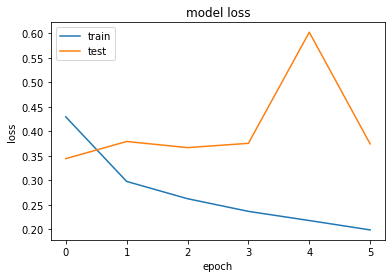

In [41]:
plot_history(history)

In [42]:
lstm_model.load_weights('checkpoint_model.hdf5')

In [43]:
#Prediction 
def predict(review):
    
    # remove non alphabetic characters
    review = re.sub('[^A-Za-z]', ' ', review) 
    
    # Stemmer
    review = review.split(" ")
    review = [w for w in review if w != ""]
    review = [stemmer.stem(w) for w in review]
    
    # remove stopwords
    review = [w for w in review if w not in stop]
    
    # get bag of words
    list_ = []
    for w in review:
        try:
            list_.append(most_freq_words[w])
        except:
            pass
    test = [list_]
    test = np.array(test)
    test = pad_sequences(test, 120)
#     pred = lstm_model.predict(test)[0][0]
    pred = lstm_model.predict(test)[0][0]
    print("Positive : ", pred)
    print("Negative : ", 1-pred)

In [44]:
# Review check for the movie Avengers
positive_review = "I have got to tell anyone who will listen that this is one of THE best adventure movies I have ever seen \ If you are a fan of epic adventure movies, then this is your dream come true \ Brilliant film from start to finish"

In [45]:
# 10-Star Reviews
predict(positive_review)

Positive :  0.46825957
Negative :  0.5317404270172119


In [46]:
# Review check for the movie Logan
negative_review = "Totally predictable and boring \ No suspense. Acting is OK. But the story was ridiculous \ Very dark, very grim"

In [47]:
# 2-star reviews
predict(negative_review)

Positive :  0.46825957
Negative :  0.5317404270172119
